In [60]:
import dataclasses
import json
import random
from collections import defaultdict, Counter
from copy import deepcopy
from dataclasses import dataclass
from typing import List, Optional, Union
from pprint import pprint
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from konlpy.tag import Mecab

slot_meta_path = "../input/data/train_dataset/slot_meta.json"
train_data_path = f"../input/data/train_dataset/train_dials.json"

slot_meta = json.load(open(slot_meta_path))
train_data = json.load(open(train_data_path))

mecab = Mecab()
mecab.pos('이순신은 조선 중기의 무신이다')


[('이순신', 'NNP'),
 ('은', 'JX'),
 ('조선', 'NNP'),
 ('중기', 'NNG'),
 ('의', 'JKG'),
 ('무신', 'NNG'),
 ('이', 'VCP'),
 ('다', 'EC')]

In [61]:
dg0 = train_data[5]
# pprint(dg0)
slot0 = dg0['dialogue'][3]
pprint(slot0)
slot1 = dg0['dialogue'][4]
pprint(slot1)
tagged_pos = mecab.pos(slot1['text'])
# pprint(tagged_pos)
nng_list = [pos[0] for pos in tagged_pos if pos[1]=='NNG']
# pprint(slot1['text'])
pprint(nng_list)

{'role': 'sys',
 'text': '네. 알겠습니다. 혹시 서울 강북구에 위치한 엄중식이라는 곳은 어떠신가요? 평점은 4.3으로 확인됩니다.'}
{'role': 'user',
 'state': ['식당-가격대-dontcare',
           '식당-지역-서울 북쪽',
           '식당-종류-중식당',
           '식당-주차 가능-yes',
           '식당-주류 판매-yes'],
 'text': '죄송하지만 이름 한번만 다시 말씀해주시겠어요?'}
['이름', '말씀']


In [62]:
keyword = '가요'

contain_keyword_sentence = []
for dg in train_data:
  for slot in dg['dialogue']:
    if keyword in slot['text']:
      contain_keyword_sentence.append(slot['text'])
contain_keyword_sentence[:5]

['안녕하세요. 문화역서울 284은 어떠신가요? 평점도 4점으로 방문객들에게 좋은 평가를 받고 있습니다.',
 '생각하고 계신 가격대가 있으신가요?',
 '외계인의맛집은 어떠신가요? 대표 메뉴는 한정식입니다.',
 '좋습니당 토요일 18:00에 1명 예약가능한가요?',
 '넹 거기 주류는 판매하나요?주차는 가능한가요?']

In [63]:
# # 전체 모든 text에 대하여 명사 (NNG) Counter
# result_count = Counter()
# for dg in train_data:
#   for slot in dg['dialogue']:
#     tagged_pos = mecab.pos(slot['text'])
#     nng_list = [pos[0] for pos in tagged_pos if pos[1] in ('NNG')]
#     result_count += Counter(nng_list)
# result_count

In [64]:
def count_freq_words(input_data, text_or_state, stopwords_list, role_list=['user','sys'], pos_type_list=['NNG']):
  # state(라벨)만 count하겠다면, user에만 state라는 key값이 있다. (sys에는 state라는 key가 없음)
  if text_or_state=='state':
    role_list = ['user']
  # 빈 Counter 객체 이용 -> return 값은 각 단어별 모든 빈도를 파악한 Counter 객체
  result_count = Counter()

  # dg : 대화 한 묶음
  for dg in tqdm(input_data):

    # slot : 대화 중 한 slot (user or sys)
    for slot in dg['dialogue']:
      # 해당 slot 발화자 user인지 sys인지 둘다인지 고려하여 실행
      if slot['role'] in role_list:
        # slot에서 실제 텍스트(text)를 카운트할지, 혹은 라벨(state)를 카운트할지
        if text_or_state == 'text':
          tagged_pos = mecab.pos(slot['text'])
          nng_list = [pos[0] for pos in tagged_pos if (pos[1] in pos_type_list) and (pos[0] not in stopwords_list)]
          result_count += Counter(nng_list)
        elif text_or_state == 'state':
          result_count += Counter(slot['state'])

  return dict(result_count)

In [65]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
%matplotlib inline 

import matplotlib 
from matplotlib import rc

# # 아래 주석부분은 한글폰트를 사용하기 위한 코드로, 최초 1회만 실행하면 됩니다.
# %config InlineBackend.figure_format = 'retina'
# !apt -qq -y install fonts-nanum

def plot_wordcloud(input_count,save=False):
  fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
  rc('font', family='NanumBarunGothic')

  wordcloud = WordCloud(
      font_path = fontpath,    # 맥에선 한글폰트 설정 잘해야함.
      background_color='white',                             # 배경 색깔 정하기
      colormap = 'Accent_r',                                # 폰트 색깔 정하기
      width = 800,
      height = 800
  )

  wordcloud_words = wordcloud.generate_from_frequencies(input_count)
  array = wordcloud.to_array()
  # print(type(array)) # numpy.ndarray
  # print(array.shape) # (800, 800, 3)
  fig = plt.figure(figsize=(8, 8))
  plt.imshow(array, interpolation="bilinear")
  plt.axis('off')
  plt.show()
  if save==True:
    fig.savefig('WordCloudPlot')

## 1. Train DataSet

In [66]:
text_or_state = 'text'
# stopwords_list = ['']
stopwords_list = ['예약','번호','감사','안녕','곳','가능','숙소','식당','택시','시간','가격대','가격','종류','지역','가요','확인']
# role_list=['user','sys']
pos_type_list = ['NNG']

train_all_text_word_count = count_freq_words(input_data = train_data,
                                  text_or_state = 'text',
                                  stopwords_list = stopwords_list, 
                                  role_list=['user','sys'], 
                                  pos_type_list=pos_type_list)

train_user_text_word_count = count_freq_words(input_data = train_data,
                                  text_or_state = 'text',
                                  stopwords_list = stopwords_list, 
                                  role_list=['user'], 
                                  pos_type_list=pos_type_list)

train_sys_text_word_count = count_freq_words(input_data = train_data,
                                  text_or_state = 'text',
                                  stopwords_list = stopwords_list, 
                                  role_list=['sys'], 
                                  pos_type_list=pos_type_list)

train_all_label_word_count = count_freq_words(input_data = train_data,
                                  text_or_state = 'state',
                                  stopwords_list = stopwords_list, 
                                  role_list=['user'], 
                                  pos_type_list=pos_type_list)


100%|██████████| 7000/7000 [00:04<00:00, 1634.54it/s]


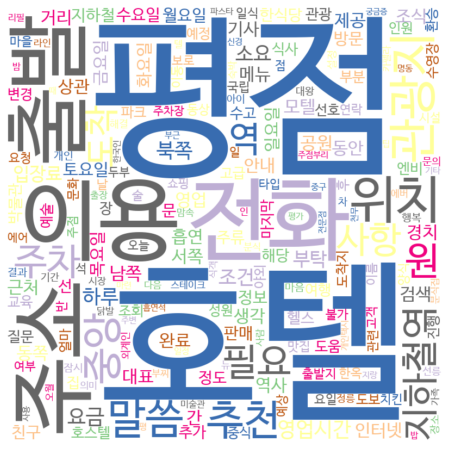

In [67]:
plot_wordcloud(train_all_text_word_count)

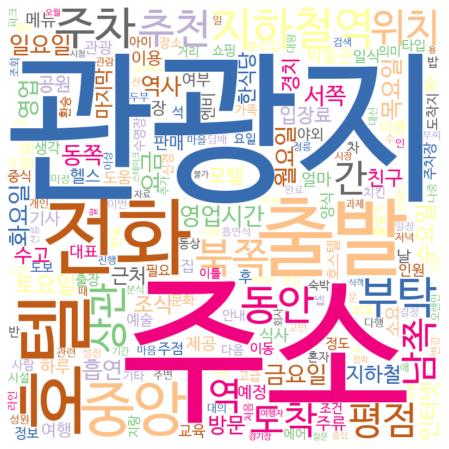

In [68]:
plot_wordcloud(train_user_text_word_count)

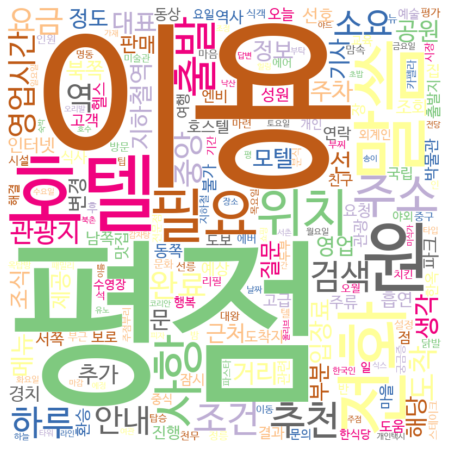

In [69]:
plot_wordcloud(train_sys_text_word_count)

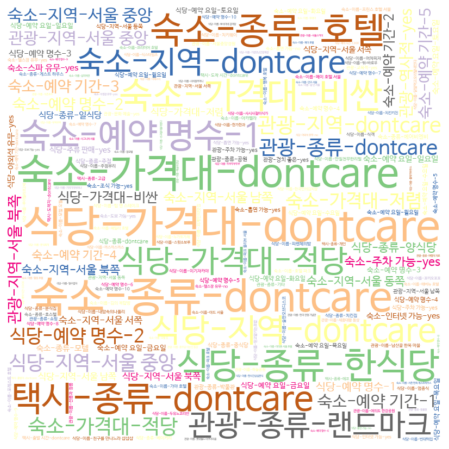

In [70]:
plot_wordcloud(train_all_label_word_count)

## 2. Eval DataSet

In [71]:
eval_slot_meta_path = "../input/data/eval_dataset/slot_meta.json"
eval_data_path = f"../input/data/eval_dataset/eval_dials.json"

eval_slot_meta = json.load(open(eval_slot_meta_path))
eval_data = json.load(open(eval_data_path))

text_or_state = 'text'
# stopwords_list = ['']
stopwords_list = ['예약','번호','감사','안녕','곳','가능','숙소','식당','택시','시간','가격대','가격','종류','지역','가요','확인']
# role_list=['user','sys']
pos_type_list = ['NNG']

eval_all_text_word_count = count_freq_words(input_data = eval_data,
                                  text_or_state = 'text',
                                  stopwords_list = stopwords_list, 
                                  role_list=['user','sys'], 
                                  pos_type_list=pos_type_list)

eval_user_text_word_count = count_freq_words(input_data = eval_data,
                                  text_or_state = 'text',
                                  stopwords_list = stopwords_list, 
                                  role_list=['user'], 
                                  pos_type_list=pos_type_list)

eval_sys_text_word_count = count_freq_words(input_data = eval_data,
                                  text_or_state = 'text',
                                  stopwords_list = stopwords_list, 
                                  role_list=['sys'], 
                                  pos_type_list=pos_type_list)

# eval_all_label_word_count = count_freq_words(input_data = eval_data,
#                                   text_or_state = 'state',
#                                   stopwords_list = stopwords_list, 
#                                   role_list=['user'], 
#                                   pos_type_list=pos_type_list)


100%|██████████| 2000/2000 [00:01<00:00, 1440.72it/s]


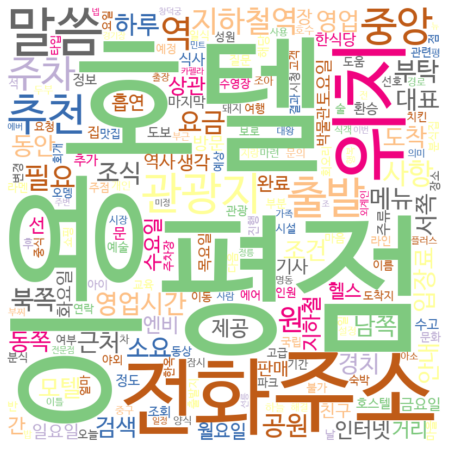

In [72]:
plot_wordcloud(eval_all_text_word_count)

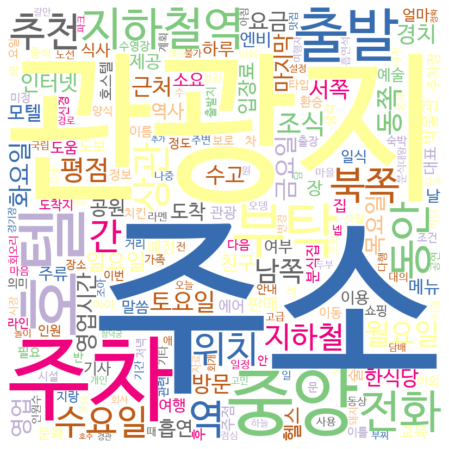

In [73]:
plot_wordcloud(eval_user_text_word_count)

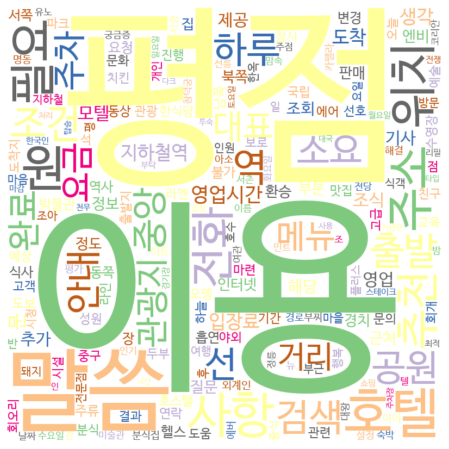

In [74]:
plot_wordcloud(eval_sys_text_word_count)